In [32]:
import subprocess
import sys

# List of required packages
required_packages = [
    "numpy", "joblib", "pandas", "matplotlib", "seaborn", "statsmodels", 
    "scikit-learn", "prophet", "xgboost", "tensorflow"
]

# Install each package if not already installed
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [ ]:
# --- Basic Data Processing Libraries ---
import numpy as np
import pandas as pd

# --- Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Time Series Analysis ---
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# --- Machine Learning Libraries ---
# Scikit-Learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report, 
    mean_squared_error, 
    mean_absolute_error
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# --- Deep Learning (TensorFlow/Keras) ---
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ELU
from tensorflow.keras.metrics import MeanSquaredError

# --- Utilities ---
import os
import joblib
import logging
import warnings
import time

# Suppress warnings
warnings.filterwarnings('ignore')

/Users/arpansharma/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Forecasting Crop Demand

In [34]:
url = "https://raw.githubusercontent.com/HarshTiwari1710/Resource-Competition-Modelling/refs/heads/main/market_data.csv"

In [35]:
market_data = pd.read_csv(url)

In [36]:
market_data

,Timestamp,Crop,Price per kg,Volume Sold per Cycle,Dump Amount
0,2014-01-05,Basil,12.408404,501.615794,25.080790
1,2014-01-05,Cilantro,13.543951,470.306395,32.921448
2,2014-01-05,Kale,13.748706,510.687517,30.641251
3,2014-01-05,Lettuce,10.771464,559.991758,22.399670
4,2014-01-05,Spinach,8.817561,469.958497,23.497925
...,...,...,...,...,...
2605,2023-12-31,Basil,15.816985,522.900091,26.145005
2606,2023-12-31,Cilantro,7.368079,458.589700,32.101279
2607,2023-12-31,Kale,16.499763,439.378824,26.362729
2608,2023-12-31,Lettuce,7.509354,516.129747,20.645190


In [37]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              2610 non-null   object 
 1   Crop                   2610 non-null   object 
 2   Price per kg           2610 non-null   float64
 3   Volume Sold per Cycle  2610 non-null   float64
 4   Dump Amount            2610 non-null   float64
dtypes: float64(3), object(2)
memory usage: 102.1+ KB


### Basic Exploration of data

In [38]:
# Check data types
print(market_data.dtypes)

Timestamp                 object
Crop                      object
Price per kg             float64
Volume Sold per Cycle    float64
Dump Amount              float64
dtype: object


In [39]:
# Convert 'Timestamp' to datetime if not already
market_data['Timestamp'] = pd.to_datetime(market_data['Timestamp'])

In [40]:
# Check for remaining NA values
print(market_data.isna().sum())


Timestamp                0
Crop                     0
Price per kg             0
Volume Sold per Cycle    0
Dump Amount              0
dtype: int64


There are no nulls in scrapped market data

In [41]:
# Find duplicate rows based on all columns
duplicate_rows = market_data[market_data.duplicated()]

# Display the duplicate rows
print("Duplicate Rows:")
duplicate_rows


Duplicate Rows:


,Timestamp,Crop,Price per kg,Volume Sold per Cycle,Dump Amount


There are no duplicated values

### Feature Engineering

In [42]:
# Temporal Features
market_data['Year'] = market_data['Timestamp'].dt.year
market_data['Month'] = market_data['Timestamp'].dt.month
market_data['Quarter'] = market_data['Timestamp'].dt.quarter
market_data['Day_of_Week'] = market_data['Timestamp'].dt.dayofweek
market_data['Day_of_Month'] = market_data['Timestamp'].dt.day
market_data['Is_Weekend'] = market_data['Day_of_Week'].isin([5, 6]).astype(int)
market_data['Week_of_Year'] = market_data['Timestamp'].dt.isocalendar().week
market_data['Days_Since_Start'] = (market_data['Timestamp'] - market_data['Timestamp'].min()).dt.days

# Season Feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
market_data['Season'] = market_data['Month'].apply(get_season)
market_data = pd.get_dummies(market_data, columns=['Season'], prefix='Season')

# Lagged Features
for lag in range(1, 4):
    market_data[f'price_lag_{lag}'] = market_data.groupby('Crop')['Price per kg'].shift(lag)
    market_data[f'volume_lag_{lag}'] = market_data.groupby('Crop')['Volume Sold per Cycle'].shift(lag)
    market_data[f'dump_lag_{lag}'] = market_data.groupby('Crop')['Dump Amount'].shift(lag)

# Rolling Statistics
for window in [3, 7]:
    market_data[f'price_roll_mean_{window}'] = market_data.groupby('Crop')['Price per kg'].shift(1).rolling(window).mean()
    market_data[f'price_roll_std_{window}'] = market_data.groupby('Crop')['Price per kg'].shift(1).rolling(window).std()

# Crop-Specific Features
market_data['crop_avg_price'] = market_data.groupby('Crop')['Price per kg'].shift(1).expanding().mean()
market_data['crop_price_volatility'] = market_data.groupby('Crop')['Price per kg'].shift(1).expanding().std()

# Interaction Features
market_data['price_to_volume_ratio'] = market_data['Price per kg'] / (market_data['Volume Sold per Cycle'] + 1e-6)
market_data['dump_to_volume_ratio'] = market_data['Dump Amount'] / (market_data['Volume Sold per Cycle'] + 1e-6)

# Trend and Difference Features
market_data['price_diff'] = market_data.groupby('Crop')['Price per kg'].diff()
market_data['price_pct_change'] = market_data.groupby('Crop')['Price per kg'].pct_change()

# Market-Wide Features
market_data['market_avg_price'] = market_data.groupby('Timestamp')['Price per kg'].transform('mean')

# Handle Missing Values
market_data = market_data.groupby('Crop').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill')).reset_index(drop=True)

# One-Hot Encode Crop column
market_data = pd.get_dummies(market_data, columns=['Crop'], prefix='Crop')

# Drop Timestamp as its not needed for modeling
market_data = market_data.drop('Timestamp', axis=1)


In [43]:
print(market_data.columns)
print(market_data.index.names)

Index(['Price per kg', 'Volume Sold per Cycle', 'Dump Amount', 'Year', 'Month',
       'Quarter', 'Day_of_Week', 'Day_of_Month', 'Is_Weekend', 'Week_of_Year',
       'Days_Since_Start', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'price_lag_1', 'volume_lag_1', 'dump_lag_1',
       'price_lag_2', 'volume_lag_2', 'dump_lag_2', 'price_lag_3',
       'volume_lag_3', 'dump_lag_3', 'price_roll_mean_3', 'price_roll_std_3',
       'price_roll_mean_7', 'price_roll_std_7', 'crop_avg_price',
       'crop_price_volatility', 'price_to_volume_ratio',
       'dump_to_volume_ratio', 'price_diff', 'price_pct_change',
       'market_avg_price', 'Crop_Basil', 'Crop_Cilantro', 'Crop_Kale',
       'Crop_Lettuce', 'Crop_Spinach'],
      dtype='object')
[None]


#### Model Training

Using XG boost to forecast price

In [44]:
# Generate lagged features for price
for lag in range(1, 4):  # Using 3 lags for this example
    market_data[f'price_lag_{lag}'] = market_data['Price per kg'].shift(lag)

# Fill missing values
market_data.fillna(method='ffill', inplace=True)

# Prepare features and target
X = market_data.drop('Price per kg', axis=1)
y = market_data['Price per kg']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import time
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Set up the parameter grid (same as before)
param_grid = {
    'colsample_bytree': [0.7, 0.8, 0.9],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [5, 10, 15],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.7, 0.8],
    'reg_lambda': [0.5, 1.0, 2.0],
    'reg_alpha': [0.0, 0.1, 0.5]
}

# Set up XGBRegressor for CPU usage
model = xgb.XGBRegressor(
    tree_method='hist',  # Changed from 'gpu_hist' to 'hist' for CPU usage
    verbosity=2
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=1000,              # Try 100 random combinations (adjust as needed)
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=3,               # Increased verbosity
    random_state=42,         # For reproducibility
    return_train_score=True, # Store training scores
    n_jobs=-1                # Use all CPU cores for parallelization
)

# Time tracking for overall process
start_time = time.time()

print("Starting randomized search on CPU...")
# Fit the random search
random_search.fit(X_train, y_train)

# Print time taken
time_taken = time.time() - start_time
print(f"Random search completed in {time_taken:.2f} seconds ({time_taken/60:.2f} minutes)")

# Print the best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print(f"Best CV Score: {-random_search.best_score_:.4f} MSE")

# Best model from random search
best_model = random_search.best_estimator_

# Evaluate on training and testing data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nModel Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"R² score on test: {r2_score(y_test, y_test_pred):.4f}")

# Print feature importances
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X_train.columns if hasattr(X_train, "columns") else [f"feature_{i}" for i in range(X_train.shape[1])]

    print("\nFeature Importances:")
    for feature, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance:.4f}")

# Optional: Show search results distribution
print("\nParameter Distribution in Top Results:")
results = random_search.cv_results_
for param in param_grid:
    top_indices = np.argsort(results['mean_test_score'])[-10:]  # Top 10 models
    top_values = [results['params'][i][param] for i in top_indices]
    value_counts = {val: top_values.count(val) for val in set(top_values)}
    print(f"{param}: {value_counts}")

In [ ]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

In [ ]:
# Create final model with best parameters
final_model = xgb.XGBRegressor(
    tree_method='hist',  
    verbosity=1,
    subsample=0.8,
    reg_lambda=0.5,
    reg_alpha=0.1,
    n_estimators=200,
    min_child_weight=5,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.9
)

# Assuming X_train, X_test, y_train, y_test are already defined
X_full = pd.concat([X_train, X_test]) if isinstance(X_train, pd.DataFrame) else np.vstack([X_train, X_test])
y_full = pd.concat([y_train, y_test]) if isinstance(y_train, pd.Series) else np.concatenate([y_train, y_test])

print(f"Training final model on full dataset with {X_full.shape[0]} samples...")

# Split the data to include a validation set for early stopping
X_train_full, X_val, y_train_full, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Fit the model with early stopping
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_val, y_val)],
    verbose=True, # Stop if no improvement after 10 rounds
)

# Save the model
joblib.dump(final_model, 'forecast_market_demand.pkl')
print("Final model saved as 'forecast_market_demand.pkl'")

# Evaluate on training and testing data
y_train_pred = final_model.predict(X_train_full)
y_test_pred = final_model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train_full, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_val, y_test_pred))
r2 = r2_score(y_val, y_test_pred)

print("\nModel Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"R² score on test: {r2:.4f}")

Training final model on full dataset with 2610 samples...
[0]	validation_0-rmse:3.20600
[1]	validation_0-rmse:2.92529
[2]	validation_0-rmse:2.67302
[3]	validation_0-rmse:2.42343
[4]	validation_0-rmse:2.20804
[5]	validation_0-rmse:2.01132
[6]	validation_0-rmse:1.82512
[7]	validation_0-rmse:1.65783
[8]	validation_0-rmse:1.50737
[9]	validation_0-rmse:1.38075
[10]	validation_0-rmse:1.25778
[11]	validation_0-rmse:1.14911
[12]	validation_0-rmse:1.07475
[13]	validation_0-rmse:0.98379
[14]	validation_0-rmse:0.90666
[15]	validation_0-rmse:0.83705
[16]	validation_0-rmse:0.77315
[17]	validation_0-rmse:0.71073
[18]	validation_0-rmse:0.65552
[19]	validation_0-rmse:0.61142
[20]	validation_0-rmse:0.56793
[21]	validation_0-rmse:0.52923
[22]	validation_0-rmse:0.49207
[23]	validation_0-rmse:0.46204
[24]	validation_0-rmse:0.43369
[25]	validation_0-rmse:0.40883
[26]	validation_0-rmse:0.38561
[27]	validation_0-rmse:0.36597
[28]	validation_0-rmse:0.34951
[29]	validation_0-rmse:0.33430
[30]	validation_0-rmse

### Example Prediction

In [ ]:
def preprocess_data(df):
    """
    Transform raw data into features required by the trained model

    Parameters:
    -----------
    df : DataFrame
        Raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount

    Returns:
    --------
    processed_df : DataFrame
        DataFrame with all required features for prediction
    """
    # Make a copy to avoid modifying the original
    data = df.copy()

    # Ensure timestamp is datetime
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])

    # Extract date features
    data['Year'] = data['Timestamp'].dt.year
    data['Month'] = data['Timestamp'].dt.month
    data['Quarter'] = data['Timestamp'].dt.quarter
    data['Day_of_Week'] = data['Timestamp'].dt.dayofweek
    data['Day_of_Month'] = data['Timestamp'].dt.day
    data['Is_Weekend'] = (data['Day_of_Week'] >= 5).astype(int)
    data['Week_of_Year'] = data['Timestamp'].dt.isocalendar().week

    # Calculate days since start
    start_date = data['Timestamp'].min()
    data['Days_Since_Start'] = (data['Timestamp'] - start_date).dt.days

    # Create season features
    data['month'] = data['Timestamp'].dt.month
    data['Season_Winter'] = ((data['month'] >= 12) | (data['month'] <= 2)).astype(int)
    data['Season_Spring'] = ((data['month'] >= 3) & (data['month'] <= 5)).astype(int)
    data['Season_Summer'] = ((data['month'] >= 6) & (data['month'] <= 8)).astype(int)
    data['Season_Fall'] = ((data['month'] >= 9) & (data['month'] <= 11)).astype(int)
    data.drop('month', axis=1, inplace=True)

    # Create one-hot encoding for crop
    crop_dummies = pd.get_dummies(data['Crop'], prefix='Crop')
    data = pd.concat([data, crop_dummies], axis=1)

    # Sort by timestamp for creating lag features
    data.sort_values(['Crop', 'Timestamp'], inplace=True)

    # Create lag features by crop
    for crop in data['Crop'].unique():
        crop_mask = data['Crop'] == crop

        # Create lag features (1, 2, 3 days)
        for lag in range(1, 4):
            data.loc[crop_mask, f'price_lag_{lag}'] = data.loc[crop_mask, 'Price per kg'].shift(lag)
            data.loc[crop_mask, f'volume_lag_{lag}'] = data.loc[crop_mask, 'Volume Sold per Cycle'].shift(lag)
            data.loc[crop_mask, f'dump_lag_{lag}'] = data.loc[crop_mask, 'Dump Amount'].shift(lag)

    # Create rolling statistics (3 and 7 days)
    for crop in data['Crop'].unique():
        crop_mask = data['Crop'] == crop

        # 3-day rolling stats
        data.loc[crop_mask, 'price_roll_mean_3'] = data.loc[crop_mask, 'Price per kg'].rolling(3).mean().shift(1)
        data.loc[crop_mask, 'price_roll_std_3'] = data.loc[crop_mask, 'Price per kg'].rolling(3).std().shift(1)

        # 7-day rolling stats
        data.loc[crop_mask, 'price_roll_mean_7'] = data.loc[crop_mask, 'Price per kg'].rolling(7).mean().shift(1)
        data.loc[crop_mask, 'price_roll_std_7'] = data.loc[crop_mask, 'Price per kg'].rolling(7).std().shift(1)

    # Calculate derived features
    data['price_to_volume_ratio'] = data['Price per kg'] / data['Volume Sold per Cycle']
    data['dump_to_volume_ratio'] = data['Dump Amount'] / data['Volume Sold per Cycle']

    # Calculate price difference and percentage change
    data['price_diff'] = data.groupby('Crop')['Price per kg'].diff()
    data['price_pct_change'] = data.groupby('Crop')['Price per kg'].pct_change() * 100

    # Calculate aggregate statistics
    crop_avg_price = data.groupby('Crop')['Price per kg'].transform('mean')
    data['crop_avg_price'] = crop_avg_price

    crop_price_volatility = data.groupby('Crop')['Price per kg'].transform('std')
    data['crop_price_volatility'] = crop_price_volatility

    daily_avg_price = data.groupby('Timestamp')['Price per kg'].transform('mean')
    data['market_avg_price'] = daily_avg_price

    # Store the target variable separately before dropping
    price = data['Price per kg'].copy() if 'Price per kg' in data.columns else None

    # Drop columns not needed for prediction
    drop_cols = ['Timestamp', 'Crop', 'Price per kg']
    data.drop([col for col in drop_cols if col in data.columns], axis=1, inplace=True)

    # Handle missing values from lag and rolling features
    data.fillna(method='bfill', inplace=True)
    data.fillna(method='ffill', inplace=True)
    data.fillna(0, inplace=True)

    return data, price

In [ ]:
def predict_with_preprocessing(new_data, model_path='forecast_market_demand.pkl'):
    """
    Preprocess raw data and make predictions

    Parameters:
    -----------
    new_data : DataFrame
        Raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount
    model_path : str
        Path to saved model

    Returns:
    --------
    predictions : array
        Predicted prices
    processed_data : DataFrame
        Processed features used for prediction
    """
    import joblib

    # Preprocess the data - unpack the tuple correctly
    processed_data, actual_prices = preprocess_data(new_data)

    # Ensure column order matches training data - UPDATED LIST WITHOUT "Price per kg"
    expected_columns = ['Volume Sold per Cycle', 'Dump Amount', 'Year', 'Month',
                      'Quarter', 'Day_of_Week', 'Day_of_Month', 'Is_Weekend', 'Week_of_Year',
                      'Days_Since_Start', 'Season_Fall', 'Season_Spring', 'Season_Summer',
                      'Season_Winter', 'price_lag_1', 'volume_lag_1', 'dump_lag_1', 'price_lag_2',
                      'volume_lag_2', 'dump_lag_2', 'price_lag_3', 'volume_lag_3', 'dump_lag_3',
                      'price_roll_mean_3', 'price_roll_std_3', 'price_roll_mean_7', 'price_roll_std_7',
                      'crop_avg_price', 'crop_price_volatility', 'price_to_volume_ratio',
                      'dump_to_volume_ratio', 'price_diff', 'price_pct_change', 'market_avg_price',
                      'Crop_Basil', 'Crop_Cilantro', 'Crop_Kale', 'Crop_Lettuce', 'Crop_Spinach']

    # Check for missing columns and add them if needed
    for col in expected_columns:
        if col not in processed_data.columns:
            processed_data[col] = 0

    # Ensure we only have the columns in expected_columns (no extras)
    processed_data = processed_data.reindex(columns=expected_columns)

    # Load model and predict
    model = joblib.load(model_path)
    predictions = model.predict(processed_data)

    return predictions, processed_data

In [ ]:
def forecast_prices(current_data, periods=30, model_path='forecast_market_demand.pkl'):
    """
    Generate forecasts for future prices based on current data

    Parameters:
    -----------
    current_data : DataFrame
        Current raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount
    periods : int
        Number of days to forecast (default 30)
    model_path : str
        Path to the saved model

    Returns:
    --------
    forecast_df : DataFrame
        DataFrame with forecasted prices by crop and date
    """
    # Make a copy of the input data
    data = current_data.copy()

    # Sort data by Timestamp to ensure chronological order
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data = data.sort_values(['Crop', 'Timestamp'])

    # Get the unique crops
    crops = data['Crop'].unique()

    # Get the last date in the dataset
    last_date = data['Timestamp'].max()

    # Create a list to store forecasts
    all_forecasts = []

    # Load the model
    model = joblib.load(model_path)

    # For each crop, generate future dates and forecast
    for crop in crops:
        # Filter data for this crop
        crop_data = data[data['Crop'] == crop].copy()

        # Store the original data to use for forecasting
        original_crop_data = crop_data.copy()

        # Create future dates
        future_dates = [last_date + timedelta(days=i+1) for i in range(periods)]

        # For each future date, create a new row and forecast
        for future_date in future_dates:
            # Create a new row with the future date
            new_row = {
                'Timestamp': future_date,
                'Crop': crop,
                # Use the last known values for these columns
                'Volume Sold per Cycle': crop_data['Volume Sold per Cycle'].iloc[-1],
                'Dump Amount': crop_data['Dump Amount'].iloc[-1]
            }

            # Convert to DataFrame
            new_row_df = pd.DataFrame([new_row])

            # Combine with historical data for feature generation
            temp_data = pd.concat([original_crop_data, new_row_df], ignore_index=True)

            # Preprocess to generate features
            processed_data, _ = preprocess_data(temp_data)

            # Get the last row (which contains our new date's features)
            features_for_prediction = processed_data.iloc[-1:].copy()

            # Ensure we have all expected columns in the right order
            expected_columns = ['Volume Sold per Cycle', 'Dump Amount', 'Year', 'Month',
                              'Quarter', 'Day_of_Week', 'Day_of_Month', 'Is_Weekend', 'Week_of_Year',
                              'Days_Since_Start', 'Season_Fall', 'Season_Spring', 'Season_Summer',
                              'Season_Winter', 'price_lag_1', 'volume_lag_1', 'dump_lag_1', 'price_lag_2',
                              'volume_lag_2', 'dump_lag_2', 'price_lag_3', 'volume_lag_3', 'dump_lag_3',
                              'price_roll_mean_3', 'price_roll_std_3', 'price_roll_mean_7', 'price_roll_std_7',
                              'crop_avg_price', 'crop_price_volatility', 'price_to_volume_ratio',
                              'dump_to_volume_ratio', 'price_diff', 'price_pct_change', 'market_avg_price',
                              'Crop_Basil', 'Crop_Cilantro', 'Crop_Kale', 'Crop_Lettuce', 'Crop_Spinach']

            for col in expected_columns:
                if col not in features_for_prediction.columns:
                    features_for_prediction[col] = 0

            features_for_prediction = features_for_prediction.reindex(columns=expected_columns)

            # Make prediction
            predicted_price = model.predict(features_for_prediction)[0]

            # Create a forecast row
            forecast = {
                'Timestamp': future_date,
                'Crop': crop,
                'Predicted_Price': predicted_price
            }
            all_forecasts.append(forecast)

            # Update the original data with the predicted price
            # This allows the next prediction to use this as history
            new_row['Price per kg'] = predicted_price
            original_crop_data = pd.concat([original_crop_data, pd.DataFrame([new_row])], ignore_index=True)

    # Convert forecasts to DataFrame
    forecast_df = pd.DataFrame(all_forecasts)

    # Add time indicators
    forecast_df['Forecast_Type'] = 'Day-by-Day'
    forecast_df['Days_Ahead'] = (forecast_df['Timestamp'] - last_date).dt.days

    # Add week and month indicators
    forecast_df['Week'] = forecast_df['Timestamp'].dt.isocalendar().week
    forecast_df['Month'] = forecast_df['Timestamp'].dt.month

    # Create weekly and monthly aggregates
    weekly_forecast = forecast_df.groupby(['Crop', 'Week']).agg(
        Avg_Weekly_Price=('Predicted_Price', 'mean'),
        First_Date=('Timestamp', 'min')
    ).reset_index()
    weekly_forecast['Forecast_Type'] = 'Weekly'

    monthly_forecast = forecast_df.groupby(['Crop', 'Month']).agg(
        Avg_Monthly_Price=('Predicted_Price', 'mean'),
        First_Date=('Timestamp', 'min')
    ).reset_index()
    monthly_forecast['Forecast_Type'] = 'Monthly'

    # Format the results for output
    next_week_forecast = forecast_df[forecast_df['Days_Ahead'] <= 7].copy()
    next_month_forecast = forecast_df[forecast_df['Days_Ahead'] <= 30].copy()

    # Return results in a dictionary for easy access
    results = {
        'daily_forecast': forecast_df,
        'next_week': next_week_forecast,
        'next_month': next_month_forecast,
        'weekly_avg': weekly_forecast,
        'monthly_avg': monthly_forecast
    }

    return results

In [ ]:
# Example usage
if __name__ == "__main__":
    # Example raw data
    raw_data = pd.DataFrame({
        'Timestamp': ['2024-01-01', '2024-01-01', '2024-01-01', '2024-01-01', '2024-01-01'],
        'Crop': ['Basil', 'Cilantro', 'Kale', 'Lettuce', 'Spinach'],
        'Price per kg': [14.5, 12.3, 15.7, 8.9, 10.2],
        'Volume Sold per Cycle': [500, 450, 520, 540, 480],
        'Dump Amount': [25, 30, 28, 22, 24]
    })

    # Make predictions
    predictions, processed_features = predict_with_preprocessing(raw_data, 'forecast_market_demand.pkl')

    # Combine raw data with predictions
    results = raw_data.copy()
    results['Predicted_Price'] = predictions

    print(results[['Timestamp', 'Crop', 'Price per kg', 'Predicted_Price']])

    Timestamp      Crop  Price per kg  Predicted_Price
0  2024-01-01     Basil          14.5        11.828945
1  2024-01-01  Cilantro          12.3        10.359092
2  2024-01-01      Kale          15.7        13.055305
3  2024-01-01   Lettuce           8.9         7.969810
4  2024-01-01   Spinach          10.2         9.005672


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def get_microgreens_forecast(current_data, periods=30, model_path='forecast_market_demand.pkl'):
    """
    Get a DataFrame containing forecasted prices for microgreens for the next 30 days

    Parameters:
    -----------
    current_data : DataFrame
        Current raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount
    periods : int
        Number of days to forecast (default 30)
    model_path : str
        Path to the saved model

    Returns:
    --------
    forecast_df : DataFrame
        DataFrame with forecasted prices for all crops over the requested period,
        containing columns: Timestamp, Crop, Predicted_Price, Days_Ahead
    """
    # Call the existing forecast_prices function
    forecast_results = forecast_prices(current_data, periods=periods, model_path=model_path)

    # Extract the daily forecast from the results
    daily_forecast = forecast_results['daily_forecast']

    # Select only the relevant columns and sort by Timestamp and Crop
    forecast_df = daily_forecast[['Timestamp', 'Crop', 'Predicted_Price', 'Days_Ahead']].copy()
    forecast_df = forecast_df.sort_values(['Timestamp', 'Crop']).reset_index(drop=True)

    # Format the price to 2 decimal places for readability
    forecast_df['Predicted_Price'] = forecast_df['Predicted_Price'].round(2)

    return forecast_df

def get_forecast_summary(current_data, periods=30, model_path='forecast_market_demand.pkl'):
    """
    Get summary DataFrames with weekly and monthly forecasts for microgreens

    Parameters:
    -----------
    current_data : DataFrame
        Current raw data with columns: Timestamp, Crop, Price per kg, Volume Sold per Cycle, Dump Amount
    periods : int
        Number of days to forecast (default 30)
    model_path : str
        Path to the saved model

    Returns:
    --------
    summary_dict : dict
        Dictionary containing:
        - 'daily': DataFrame with daily forecasts
        - 'weekly': DataFrame with weekly average forecasts
        - 'monthly': DataFrame with monthly average forecasts
    """
    # Call the existing forecast_prices function
    forecast_results = forecast_prices(current_data, periods=periods, model_path=model_path)

    # Extract the different forecast types
    daily_forecast = forecast_results['daily_forecast']
    weekly_forecast = forecast_results['weekly_avg']
    monthly_forecast = forecast_results['monthly_avg']

    # Format the daily forecast
    daily_df = daily_forecast[['Timestamp', 'Crop', 'Predicted_Price', 'Days_Ahead']].copy()
    daily_df = daily_df.sort_values(['Timestamp', 'Crop']).reset_index(drop=True)
    daily_df['Predicted_Price'] = daily_df['Predicted_Price'].round(2)

    # Format the weekly forecast
    weekly_df = weekly_forecast[['Crop', 'Week', 'Avg_Weekly_Price', 'First_Date']].copy()
    weekly_df = weekly_df.sort_values(['Week', 'Crop']).reset_index(drop=True)
    weekly_df['Avg_Weekly_Price'] = weekly_df['Avg_Weekly_Price'].round(2)

    # Format the monthly forecast
    monthly_df = monthly_forecast[['Crop', 'Month', 'Avg_Monthly_Price', 'First_Date']].copy()
    monthly_df = monthly_df.sort_values(['Month', 'Crop']).reset_index(drop=True)
    monthly_df['Avg_Monthly_Price'] = monthly_df['Avg_Monthly_Price'].round(2)

    # Return all forecasts in a dictionary
    return {
        'daily': daily_df,
        'weekly': weekly_df,
        'monthly': monthly_df
    }

# Example usage
if __name__ == "__main__":
    # Example current data
    raw_data = pd.DataFrame({
        'Timestamp': ['2025-01-01', '2025-01-01', '2025-01-01', '2025-01-01', '2025-01-01',
                     '2025-01-02', '2025-01-02', '2025-01-02', '2025-01-02', '2025-01-02',
                     '2025-01-03', '2025-01-03', '2025-01-03', '2025-01-03', '2025-01-03'],
        'Crop': ['Basil', 'Cilantro', 'Kale', 'Lettuce', 'Spinach'] * 3,
        'Price per kg': [14.5, 12.3, 15.7, 8.9, 10.2,
                        14.8, 12.1, 15.5, 9.1, 10.4,
                        14.6, 12.5, 15.8, 9.0, 10.3],
        'Volume Sold per Cycle': [500, 450, 520, 540, 480] * 3,
        'Dump Amount': [25, 30, 28, 22, 24] * 3
    })

    # Get the forecast for the next 30 days
    forecast = get_microgreens_forecast(raw_data)

    # Print the first 10 rows
    print("Next 30 Days Forecast (showing first 10 rows):")
    print(forecast.head(10))

    # Get summary forecasts
    summary = get_forecast_summary(raw_data)

    # Print weekly forecast
    print("\nWeekly Forecast Summary:")
    print(summary['weekly'])

    # Print monthly forecast
    print("\nMonthly Forecast Summary:")
    print(summary['monthly'])

Next 30 Days Forecast (showing first 10 rows):
   Timestamp      Crop  Predicted_Price  Days_Ahead
0 2025-01-04     Basil        14.900000           1
1 2025-01-04  Cilantro        12.880000           1
2 2025-01-04      Kale        16.290001           1
3 2025-01-04   Lettuce         9.300000           1
4 2025-01-04   Spinach        10.580000           1
5 2025-01-05     Basil        15.150000           2
6 2025-01-05  Cilantro        13.490000           2
7 2025-01-05      Kale        16.730000           2
8 2025-01-05   Lettuce         9.430000           2
9 2025-01-05   Spinach        10.700000           2

Weekly Forecast Summary:
        Crop  Week  Avg_Weekly_Price First_Date
0      Basil     1         15.030000 2025-01-04
1   Cilantro     1         13.180000 2025-01-04
2       Kale     1         16.510000 2025-01-04
3    Lettuce     1          9.370000 2025-01-04
4    Spinach     1         10.640000 2025-01-04
5      Basil     2         16.309999 2025-01-06
6   Cilantro     2 

## Optimal Resource Prediction

In [6]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [7]:
url2 = "https://raw.githubusercontent.com/HarshTiwari1710/Resource-Competition-Modelling/refs/heads/main/microgreen_data.csv"

In [8]:
microgreen_data = pd.read_csv(url2)

In [9]:
microgreen_data

,Timestamp,Crop,Light,Temperature,Humidity,CO2,Soil Moisture,pH,EC,Yield
0,2023-12-07 17:00:00,Cilantro,105.736518,20.952548,63.893572,670.978551,60,6.200000,1.499630,71.998235
1,2021-09-29 21:00:00,Spinach,137.747256,17.651421,57.042042,559.045773,60,6.200000,1.484339,76.933832
2,2023-04-30 23:00:00,Basil,173.989170,21.597430,65.194192,756.892206,60,6.233999,1.503028,96.039256
3,2021-05-28 07:00:00,Cilantro,121.995423,20.330052,65.501186,698.954423,60,6.200000,1.498268,80.877765
4,2021-06-17 18:00:00,Basil,191.575541,20.191907,63.001078,798.237471,60,6.419697,1.742287,105.101027
...,...,...,...,...,...,...,...,...,...,...
219240,2021-05-04 01:00:00,Lettuce,124.009275,18.816990,60.012641,600.000000,60,6.200000,1.303708,71.274423
219241,2024-02-16 19:00:00,Basil,195.013300,21.453970,61.215462,660.094544,60,6.182847,1.452938,80.499569
219242,2023-11-14 17:00:00,Lettuce,137.076682,18.367387,62.418893,600.000000,60,6.200000,1.393570,78.473788
219243,2024-11-26 00:00:00,Spinach,114.903236,17.614397,62.412407,558.369308,60,6.200000,1.438877,83.816762


In [10]:
microgreen_data.isnull().sum()

Timestamp        0
Crop             0
Light            0
Temperature      0
Humidity         0
CO2              0
Soil Moisture    0
pH               0
EC               0
Yield            0
dtype: int64

In [11]:
microgreen_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219245 entries, 0 to 219244
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      219245 non-null  object 
 1   Crop           219245 non-null  object 
 2   Light          219245 non-null  float64
 3   Temperature    219245 non-null  float64
 4   Humidity       219245 non-null  float64
 5   CO2            219245 non-null  float64
 6   Soil Moisture  219245 non-null  int64  
 7   pH             219245 non-null  float64
 8   EC             219245 non-null  float64
 9   Yield          219245 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 16.7+ MB


In [15]:
microgreen_data.drop('Timestamp', axis=1, inplace=True)

In [16]:
microgreen_data

,Crop,Light,Temperature,Humidity,CO2,Soil Moisture,pH,EC,Yield,Year,Month,Quarter,Day_of_Week
0,Cilantro,105.736518,20.952548,63.893572,670.978551,60,6.200000,1.499630,71.998235,2023,12,4,3
1,Spinach,137.747256,17.651421,57.042042,559.045773,60,6.200000,1.484339,76.933832,2021,9,3,2
2,Basil,173.989170,21.597430,65.194192,756.892206,60,6.233999,1.503028,96.039256,2023,4,2,6
3,Cilantro,121.995423,20.330052,65.501186,698.954423,60,6.200000,1.498268,80.877765,2021,5,2,4
4,Basil,191.575541,20.191907,63.001078,798.237471,60,6.419697,1.742287,105.101027,2021,6,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219240,Lettuce,124.009275,18.816990,60.012641,600.000000,60,6.200000,1.303708,71.274423,2021,5,2,1
219241,Basil,195.013300,21.453970,61.215462,660.094544,60,6.182847,1.452938,80.499569,2024,2,1,4
219242,Lettuce,137.076682,18.367387,62.418893,600.000000,60,6.200000,1.393570,78.473788,2023,11,4,1
219243,Spinach,114.903236,17.614397,62.412407,558.369308,60,6.200000,1.438877,83.816762,2024,11,4,1


### Resource Generator model

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ELU
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt


# Features and target for model
features = microgreen_data[['Crop']]
target = microgreen_data[['Light', 'Temperature', 'Humidity', 'CO2', 'Soil Moisture', 'pH', 'EC']]

# Preprocessing
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['Crop'])
])

X = preprocessor.fit_transform(features)
y = target.values

# Save preprocessor for Streamlit app
joblib.dump(preprocessor, 'preprocessor_resource_model.pkl')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
input_dim = X_train.shape[1]

model1 = Sequential([
    Dense(128, input_dim=input_dim),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),
    Dense(96),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),
    Dense(7, activation='relu')  # 7 environmental outputs
])

model1.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# Train the model
history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Save the model
model1.save('resource_generator_model.h5')
print("✅ Model 1 saved as 'resource_generator_model.h5'")

Epoch 1/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 40689.0195 - mae: 103.1460 - val_loss: 20565.1035 - val_mae: 62.3614
Epoch 2/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 20619.3340 - mae: 65.8213 - val_loss: 14066.9004 - val_mae: 54.5683
Epoch 3/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 14326.4258 - mae: 58.4371 - val_loss: 14061.9492 - val_mae: 54.3543
Epoch 4/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 13762.4385 - mae: 56.5997 - val_loss: 3242.4795 - val_mae: 25.9939
Epoch 5/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3702.9341 - mae: 30.2453 - val_loss: 3244.8591 - val_mae: 26.1120
Epoch 6/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 3649.4890 - mae: 29.7654 - val_loss: 3239.3096 - val_mae: 25.8997
Epoch 7/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 3607.3606 - mae: 29.4832 - val_loss: 3245.7415 - val_mae: 26.0674
Epoch 8/50
2741/2741 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 3599.1582 - mae: 29.4131 - val_los

✅ Model 1 saved as 'resource_generator_model.h5'


In [46]:
# Load model WITHOUT compiling (bypasses custom loss error)
resource_model = load_model('resource_generator_model.h5', compile=False)

# Load preprocessor
resource_preprocessor = joblib.load('preprocessor_resource_model.pkl')

# Prepare data
features = microgreen_data[['Crop']]
targets = microgreen_data[['Light', 'Temperature', 'Humidity', 'CO2', 'Soil Moisture', 'pH', 'EC']]

X = resource_preprocessor.transform(features)
y = targets.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions
train_pred = resource_model.predict(X_train)
test_pred = resource_model.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Resource Generator Model RMSE:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

5482/5482 ━━━━━━━━━━━━━━━━━━━━ 4s 772us/step
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step
Resource Generator Model RMSE:
Train RMSE: 56.8914
Test RMSE: 56.9229


### Yield Prediction model

In [ ]:
# Features and target for model
features = microgreen_data[['Crop', 'Light', 'Temperature', 'Humidity', 'CO2', 'Soil Moisture', 'pH', 'EC']]
target = microgreen_data['Yield']

# Preprocessing
categorical_features = ['Crop']
numerical_features = ['Light', 'Temperature', 'Humidity', 'CO2', 'Soil Moisture', 'pH', 'EC']

categorical_transformer = OneHotEncoder()
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

X = preprocessor.fit_transform(features)

# Save preprocessor for Streamlit app
joblib.dump(preprocessor, 'preprocessor_yield_model.pkl')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# Build the model
input_dim = X_train.shape[1]

model2 = Sequential([
    Dense(256, input_shape=(input_dim,)),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(224),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(192),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(160),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128),
    ELU(alpha=1.0),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='relu')
])

model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model2.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1,validation_data=(X_test, y_test))

# Save the model

model2.save('yield_predictor_model.h5')
print("Yield predictor model saved successfully.")


In [28]:
# Make predictions
train_predictions = model2.predict(X_train)
test_predictions = model2.predict(X_test)

# Initialize separate metric objects for train and test
mse_train = MeanSquaredError()
mse_test = MeanSquaredError()

# Calculate Train RMSE
mse_train.update_state(y_train, train_predictions)
train_rmse = np.sqrt(mse_train.result().numpy())

# Calculate Test RMSE
mse_test.update_state(y_test, test_predictions)
test_rmse = np.sqrt(mse_test.result().numpy())

# Print the RMSE results
print(f"✅ Train RMSE: {train_rmse:.5f}")
print(f"✅ Test RMSE: {test_rmse:.5f}")

5482/5482 ━━━━━━━━━━━━━━━━━━━━ 3s 562us/step
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step
✅ Train RMSE: 9.10897
✅ Test RMSE: 9.12078


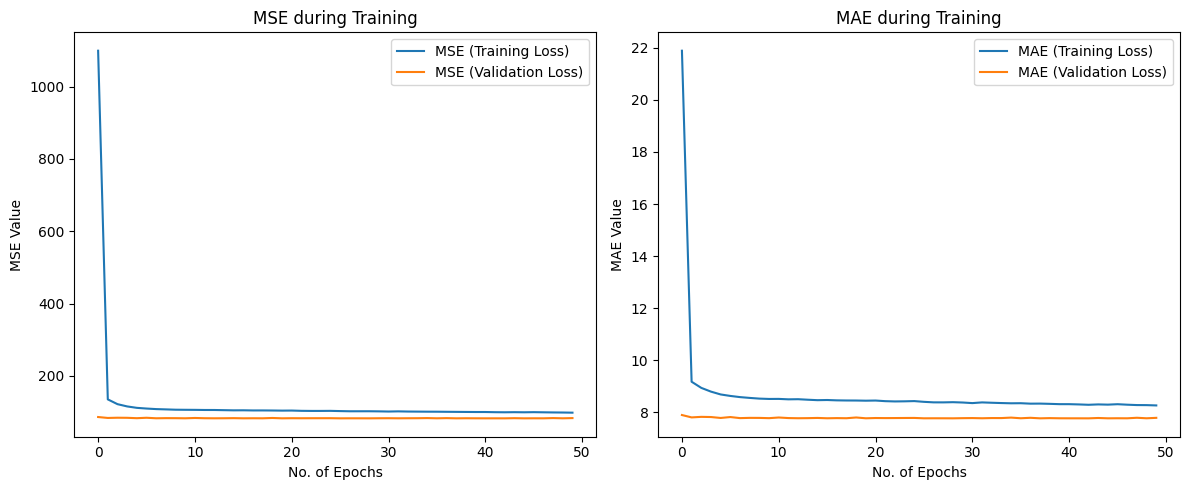

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='MSE (Training Loss)')
plt.plot(history.history['val_loss'], label='MSE (Validation Loss)')
plt.title('MSE during Training')
plt.ylabel('MSE Value')
plt.xlabel('No. of Epochs')
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (Training Loss)')
plt.plot(history.history['val_mae'], label='MAE (Validation Loss)')
plt.title('MAE during Training')
plt.ylabel('MAE Value')
plt.xlabel('No. of Epochs')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

### Testing optimal resource prediction models

In [ ]:
def get_best_resource_config(crop_name: str, num_configs: int = 10):
    """
    Generate multiple resource configurations for a given crop,
    predict yield for each using the trained yield predictor model,
    and return the config with the highest predicted yield.

    Parameters:
    -----------
    crop_name : str
        Name of the crop (e.g., "Kale")

    num_configs : int
        Number of resource configurations to generate

    Returns:
    --------
    dict : Optimized resource configuration with predicted yield
    """
    # Load both models
    resource_model = load_model('resource_generator_model.h5', compile=False)
    yield_model = load_model('yield_predictor_model.h5', compile=False)

    # Load both preprocessors
    resource_preprocessor = joblib.load('preprocessor_model2.pkl')
    yield_preprocessor = joblib.load('preprocessor_yield_model.pkl')

    # Step 1: Create input dataframe for generator
    crop_df = pd.DataFrame({'Crop': [crop_name] * num_configs, 'Yield': np.random.uniform(0.8, 1.2, num_configs)})

    # Preprocess for resource model
    resource_input = resource_preprocessor.transform(crop_df)

    # Predict resources using generator
    generated_resources = resource_model.predict(resource_input)

    # Recombine crop + resources for yield prediction
    resource_columns = ['Light', 'Temperature', 'Humidity', 'CO2', 'pH', 'EC', 'Soil Moisture']
    full_data = pd.DataFrame(generated_resources, columns=resource_columns)
    full_data.insert(0, 'Crop', crop_name)  # Add crop column for encoding

    # Preprocess for yield model
    yield_input = yield_preprocessor.transform(full_data)

    # Predict yields
    predicted_yields = yield_model.predict(yield_input)

    # Find best configuration
    best_index = np.argmax(predicted_yields)
    best_config = full_data.iloc[best_index].to_dict()
    best_config['Predicted_Yield'] = float(predicted_yields[best_index])

    return best_config

In [41]:
result = get_best_resource_config("Kale")
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
{'Crop': 'Kale', 'Light': 0.0, 'Temperature': 19.147363662719727, 'Humidity': 57.306800842285156, 'CO2': 502.6202392578125, 'pH': 60.0, 'EC': 6.101212501525879, 'Soil Moisture': 1.4586565494537354, 'Predicted_Yield': 84.16360473632812}
